In [1]:
import numpy as np
import matplotlib.pyplot as plt
from uncertainty_utils import *
import controlpy
import tqdm
# matplotlib.rcParams['text.usetex'] = True
plt.rc('font', size=16)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'large'

### Problem setup
Assume the following state space model:
$$ x_{k+1} = Ax_k + Bu_k + w_k $$
With known noise covariance, and known initial state. We have an initial guess of the system dynamics: 
$$ A_{init} = A + \Delta^A, \\ B_{init} = B + \Delta^B  $$
With the estimated dynamics, we synthesize an infinite horizon LQR controller, which we use for control for a fixed amount of time. When the finite length horizon terminates, we create new estimates of the dynamics from the state-input trajectory as follows:
$$ A^*, B^*\min_{A,B} \sum_{i=0}^{N-1} ||A\hat{x}_i + Bu_i - \hat{x}_{i+1}||_2^2 + \lambda||[A, B]||_F^2$$
 We synthesize a new LQR controller, and perform another episode of control with the new system id, and analyze the convergence of the estimates and trajectories. 

In [16]:
# Dynamics
A_true = np.array([[1,.1],[0,1]])
B_true = np.array([0,1]).reshape((2,1))
N = A_true.shape[0]
M = B_true.shape[1]
x_init = np.array([5, 2])
input_limits = 100 * np.array([-1,1])

# LQR Cost:
Q = np.eye(N)
R = np.eye(M)

# Estimation and Simulation
process_noise_var = 5e-2
process_noise = process_noise_var * np.eye(N)

# Experiment details
num_iterations = 500
regularization = 1e-12
episode_length = 200
num_data_points = 10
id_noise_std = 1e0
sigma_init_id_error = 5e-2
create_animation = False
save_figs = True
save_dir = "model_lqr_expts_svd/exp_3/"

def sim_traj(A, B, K, Q, R, process_noise, x_init, N=50, input_limits=np.array([-1e9, 1e9]), W=None, input_noise=0):
    x_traj = [x_init]
    u_traj = []

    h = lambda x,u: x.T @ Q @ x + u.T @ R @ u
    cost = 0
    
    input_noises = np.random.randn(R.shape[0], N) * input_noise if input_noise > 0 else np.zeros((R.shape[0], N))
    
    for i in range(N):
        u = np.minimum(np.maximum(input_limits[0], - K @ x_traj[-1]), input_limits[1]) + input_noises[:,i]
        w = W[i,:] if W is not None else np.random.multivariate_normal(np.zeros(x_init.shape[0]), process_noise)
        x_next = A @ x_traj[-1] + B @ u + w
        cost += h(x_traj[-1], u)

        x_traj.append(x_next)
        u_traj.append(u)
    return np.array(x_traj), np.array(u_traj), cost

def is_stable(A):
    return np.all(np.abs(np.linalg.eigvals(A)) < 1)

## Constants

In [17]:
TRAJ_CE = "state traj ce"
INPUT_TRAJ_CE = "input trajectory ce"

TRAJ_STOCH = "state traj stoch"
INPUT_TRAJ_STOCH = "input trajectory stoch"

COST_CE = "cost certainty equivalence"
COST_STOCH = "cost stochastic"

ERROR = "regression error"
COV = "covariance"
A_EST = "A_est"
B_EST = "B_est"

GAIN_CE = "K_ce"
GAIN_STOCH = "K_stoch"

STABLE_CE = "stable ce"
STABLE_STOCH = "stable stoch"

CONVERGED = "converged"

def init_experiment():
    data = {}
    data[TRAJ_CE] = []
    data[INPUT_TRAJ_CE] = []
    
    data[TRAJ_STOCH] = []
    data[INPUT_TRAJ_STOCH] = []
    
    data[COST_CE] = []
    data[COST_STOCH] = []
    
    data[ERROR] = []
    data[COV] = []
    data[A_EST] = []
    data[B_EST] = []
    data[GAIN_CE] = []
    data[GAIN_STOCH] = []
    data["process noise variance"] = process_noise_var
    data[STABLE_CE] = []
    data[STABLE_STOCH] = []
    data[CONVERGED] = []
    return data

### Show an initial run with the true dynamics

In [28]:
K_opt, p, evals= controlpy.synthesis.controller_lqr_discrete_time(A_true, B_true, Q, R)
print(K_opt, p, evals)
Q_hat = np.copy(Q)
Q_hat[1,1] = 10
K_opt_2, _, _= controlpy.synthesis.controller_lqr_discrete_time(A_true, B_true, Q_hat, R)
# print(K_opt)
def get_true_trajectory(episode_length):
    x_init_sim = x_init + np.random.multivariate_normal(np.zeros(N), process_noise)
    x_traj, u_traj, true_opt_cost = sim_traj(A_true, B_true, K_opt_2, Q, R, process_noise, x_init_sim, N=episode_length, input_limits=input_limits, input_noise=id_noise_std)
    return x_traj, u_traj, true_opt_cost

[[0.95124922 1.09512492]] [[1.15124922e+31 1.05124922e+30]
 [1.05124922e+30 1.10512492e+30]] [9.04875078e-01 1.11022302e-16]


In [24]:
true_lqr_costs = []
for i in tqdm.tqdm(range(num_iterations)):
    x_init_sim = x_init + np.random.multivariate_normal(np.zeros(N), process_noise)
    x_traj, u_traj, true_opt_cost = sim_traj(A_true, B_true, K_opt, Q, R, process_noise, x_init_sim, N=episode_length)
    true_lqr_costs.append(true_opt_cost)

print(np.mean(true_lqr_costs))


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:37<00:00, 13.16it/s]


503.56264330240145


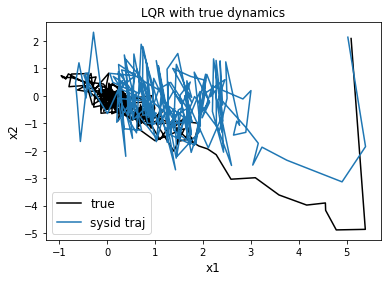

In [25]:
plt.plot(x_traj[:,0], x_traj[:,1],'k')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("LQR with true dynamics")
x_traj_id, u_traj_id, true_opt_cost = get_true_trajectory(episode_length)
plt.plot(x_traj_id[:,0], x_traj_id[:,1], "tab:blue")
plt.legend(("true", "sysid traj"))

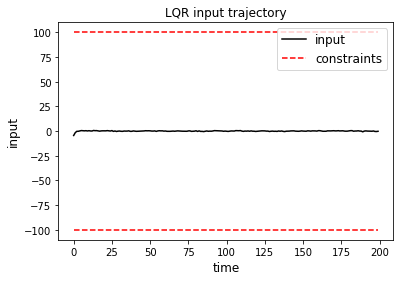

In [7]:
plt.plot(u_traj, "k")
plt.plot(np.ones(len(u_traj)) * input_limits[0], "r--")
plt.plot(np.ones(len(u_traj)) * input_limits[1], "r--")
plt.xlabel("time")
plt.ylabel("input")
plt.title("LQR input trajectory")
plt.legend(("input", "constraints"))

## Setup Ricatti Solvers

In [8]:
data = init_experiment()
A_est = A_true + sigma_init_id_error * np.random.randn(N,N) * process_noise_var
B_est = B_true + sigma_init_id_error * np.random.randn(N,M) * process_noise_var

x_init_true = x_init + np.random.multivariate_normal(np.zeros(N), process_noise)

K, _, _= controlpy.synthesis.controller_lqr_discrete_time(A_est, B_est, Q, R)


In [9]:
def iterate_are(P_next, A_hat, B_hat, Q, R, S, model_cov, sigma_w, lr=1):
    n = A_hat.shape[0]
    m = B_hat.shape[1]
    Q_hat = model_cov[:n,:n]
    R_hat = model_cov[n:,n:]
    S_hat = model_cov[:n, n:]
    gamma = np.trace(P_next @ sigma_w)
    F = - np.linalg.inv(R + gamma * R_hat + B_hat.T @ P_next @ B_hat) @  (S.T  + gamma * S_hat.T +  B_hat.T @ P_next @ A_hat)
    P_curr = Q + gamma * Q_hat - (S + gamma * S_hat + A_hat.T @ P_next @ B_hat) @ np.linalg.inv(R + gamma * R_hat + B_hat.T @ P_next @ B_hat) @ (S.T + gamma * S_hat.T + B_hat.T @ P_next @ A_hat) + A_hat.T @ P_next @ A_hat
    P_curr = lr * P_curr + (1 - lr) * P_next
    return P_curr, F

def solve_mod_are(A_hat, B_hat, Q, R, model_cov, sigma_w, tol=1e-10, max_iter=500):
    S = np.zeros((Q.shape[0], R.shape[0]))
    P = scipy.linalg.solve_discrete_are(A_hat, B_hat, Q, R,s=S)
    converged = False
    P_curr = P
    for i in range(max_iter):
        P_curr, F = iterate_are(P, A_hat, B_hat, Q, R, S, model_cov, sigma_w)
        if np.linalg.norm(P - P_curr) <= tol:
            converged = True
            break
        P = P_curr
    return P, F, converged

## Show solver converges

In [10]:
K_lqr, P_ce, _ = controlpy.synthesis.controller_lqr_discrete_time(A_est, B_est, Q, R)
Ps = [P_ce]
Fs = []
num_its = 500
S = np.zeros((Q.shape[0], R.shape[0]))
for i in range(num_its):
    P_curr, F_curr = iterate_are(Ps[-1], A_est, B_est, Q, R, S, sigma_init_id_error * np.eye(N + M), process_noise)
    Ps.append(P_curr)
    Fs.append(F_curr)
P_stoch = Ps[-1]
PP, F, conv = solve_mod_are(A_est, B_est, Q, R, sigma_init_id_error * np.eye(N + M), process_noise)
print(np.linalg.norm(PP - P_stoch))
print(np.linalg.norm(P_ce - PP), np.linalg.norm(K + F))

5.064553879642384e-10
0.46237645040568515 2.3264859050485856e-11


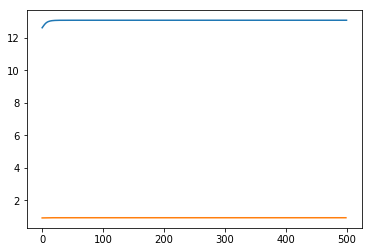

In [11]:
P_norms = [np.linalg.norm(P) for P in Ps]
F_norms = [np.linalg.norm(F) for F in Fs]
plt.plot(P_norms)
plt.plot(F_norms)

### Run iterative LQG + system ID

In [12]:
def run_experiment(num_data_pts, cov_multiplier=1):
    data = init_experiment()

    for _ in tqdm.tqdm(range(num_iterations)):
        x_traj_id, u_traj_id, cost_id = get_true_trajectory(num_data_pts)
        
        A_est, B_est, cov, error = single_traj_regression(x_traj_id, u_traj_id, regularization)

        x_init_sim = x_init + np.random.multivariate_normal(np.zeros(N), process_noise)
        K_ce, P_ce, _= controlpy.synthesis.controller_lqr_discrete_time(A_est, B_est, Q, R)
        P_stoch, F, converged = solve_mod_are(A_est, B_est, Q, R, cov_multiplier * cov, process_noise)

        W = np.random.multivariate_normal(np.zeros(x_init.shape[0]), process_noise, size=episode_length)
        x_traj_ce, u_traj_ce, cost_ce = sim_traj(A_true, B_true, K_ce, Q, R, process_noise, x_init_sim,
                                                        N=episode_length, W=W)
        data[COST_CE].append(cost_ce)
        data[STABLE_CE].append(is_stable(A_true - B_true @ K_ce))
        data[CONVERGED].append(converged)
        data[TRAJ_CE].append(x_traj_ce)
        data[INPUT_TRAJ_CE].append(u_traj_ce)
        data[COV].append(cov)
        data[ERROR].append(error)
        data[A_EST].append(A_est)
        data[B_EST].append(B_est)
        data[GAIN_CE].append(K_ce)
        if converged:
            K_stoch = -F
            x_traj_stoch, u_traj_stoch, cost_stoch = sim_traj(A_true, B_true, K_stoch, Q, R, process_noise, x_init_sim,
                                                        N=episode_length, W=W)

            data[COST_STOCH].append(cost_stoch)
            data[GAIN_STOCH].append(K_stoch)
            data[TRAJ_STOCH].append(x_traj_stoch)
            data[INPUT_TRAJ_STOCH].append(u_traj_stoch)
            data[STABLE_STOCH].append(is_stable(A_true - B_true @ K_stoch))
            
    return data

In [13]:
data = run_experiment(num_data_points, cov_multiplier=1)

100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 31.70it/s]


## Plot results

mean CE cost: 93244790664700428288.000000, standard dev: 1986839977189445992448.000000, percent stable: 0.870000
mean STOCH cost: 1975375024532384.500000, standard dev: 42933968215198400.000000, percent stable: 0.878099


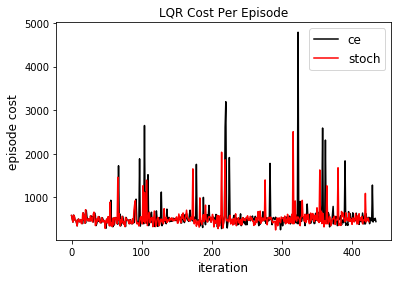

In [14]:
plt.plot(np.array(data[COST_CE])[data[STABLE_CE]], 'k')
plt.plot(np.array(data[COST_STOCH])[data[STABLE_STOCH]], "r")
# plt.plot(true_opt_cost * np.ones(num_iterations), "b")
plt.xlabel("iteration")
plt.ylabel("episode cost")
plt.title("LQR Cost Per Episode")
plt.legend(("ce", "stoch", "true LQR optimal"))
# plt.ylim((300,10000))
print("mean CE cost: %f, standard dev: %f, percent stable: %f" % (np.mean(data[COST_CE][1:]), np.std(data[COST_CE][1:]), np.sum(data[STABLE_CE])/ len(data[STABLE_CE])))
print("mean STOCH cost: %f, standard dev: %f, percent stable: %f" % (np.mean(data[COST_STOCH]), np.std(data[COST_STOCH]), np.sum(data[STABLE_STOCH])/ len(data[STABLE_STOCH])))

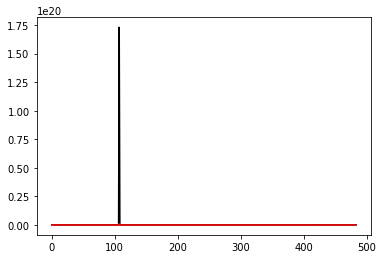

In [15]:
plt.plot(np.array(data[COST_CE])[data[CONVERGED]], 'k')
plt.plot(np.array(data[COST_STOCH]), "r")
# plt.ylim((1000,5000))

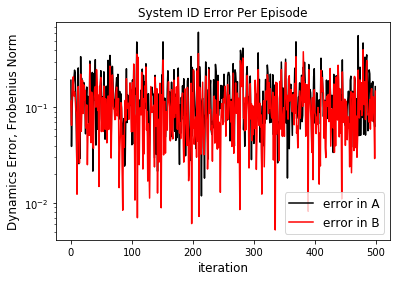

In [16]:
A_error = [np.linalg.norm(A_est - A_true) for A_est in data[A_EST]]
B_error = [np.linalg.norm(B_est - B_true) for B_est in data[B_EST]]
plt.semilogy(A_error, "k")
plt.semilogy(B_error, "r")
plt.xlabel("iteration")
plt.ylabel("Dynamics Error, Frobenius Norm")
plt.title("System ID Error Per Episode")
plt.legend(("error in A", "error in B"))

Text(0.5,1,'RMSE of Sys ID Per Episode')

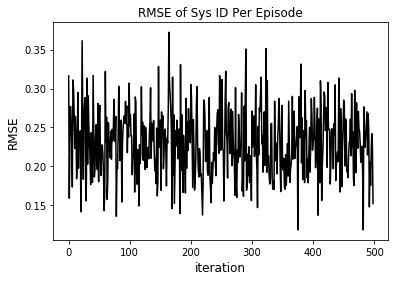

In [17]:
est_errors = [np.mean(np.linalg.norm(err, axis=1)) for err in data[ERROR][1:]]
plt.plot(est_errors,"k")
plt.xlabel("iteration")
plt.ylabel("RMSE")
plt.title("RMSE of Sys ID Per Episode")

-9.195010757680638


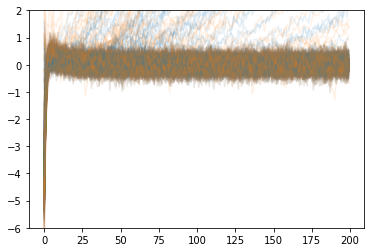

In [18]:
min_u = 1e9
for u1, u2 in zip(data[INPUT_TRAJ_STOCH], data[INPUT_TRAJ_CE]):
    plt.plot(u1, "tab:blue", alpha=0.1)
    plt.plot(u2, "tab:orange", alpha=0.1)
    min_u = np.min(u2) if np.min(u2) < min_u else min_u
plt.ylim(-6,2)
print(min_u)

In [19]:
np.where(np.logical_and(np.array(data[COST_CE]) > 8000, data[STABLE_CE]))

(array([], dtype=int64),)

## RUN Multiple Experiments

In [20]:
num_samples = 20
sample_sizes = np.logspace(0,3, num=num_samples, dtype=int)
sample_sizes = sample_sizes[sample_sizes > 3]
exp_data = [run_experiment(num_data_points, cov_multiplier=1) for num_data_points in sample_sizes]

100%|███████████████████████████████████████████████████████████████████████| 500/500 [01:52<00:00,  4.46it/s]


In [21]:
if save_figs:
    np.savez(save_dir + "low_noise_constr_data.npz", exp_data=exp_data)

## Plot results

In [22]:
figsize = (8,5)
def pct_stable(data):
    pct_ce = np.sum(data[STABLE_CE])/ len(data[STABLE_CE])
    pct_stoch = np.sum(data[STABLE_STOCH])/ len(data[STABLE_STOCH])
    return pct_ce, pct_stoch
    
def plot_with_bars(x, y, color="b", alpha=0.3, loglog=False):
    means, hi, lo = zip(*[(np.mean(yi), np.max(yi), np.min(yi)) if len(yi)>0 else (np.nan, np.nan, np.nan) for yi in y])
    if loglog:
        plt.loglog(x,means,color)
    else:
        plt.plot(x, means, color)
    plt.fill_between(x, hi, lo, color=color, alpha=alpha)
    
def plot_with_bars_qts(x, y, color="b", alpha=0.3, loglog=False):
    means, hi, lo = zip(*[(np.quantile(yi,0.5), np.quantile(yi,0.25), np.quantile(yi,0.75)) if len(yi)>0 else (np.nan, np.nan, np.nan) for yi in y])
    if loglog:
        plt.loglog(x,means,color)
    else:
        plt.plot(x, means, color)
    plt.fill_between(x, hi, lo, color=color, alpha=alpha)
    
def plot_with_bars_sd(x, y, color="b", alpha=0.3):
    means, stds = zip(*[(np.mean(yi), np.std(yi)) if len(yi)>0 else (np.nan, np.nan, np.nan) for yi in y])
    means = np.array(means)
    stds = np.array(stds)
    plt.plot(x, means, color)
    hi = means + 2 * stds
    lo = np.maximum(means - 2 * stds,0)
    plt.fill_between(x, hi, lo, color=color, alpha=alpha)
    
stable_ce, stable_stoch = zip(*[pct_stable(d) for d in exp_data])

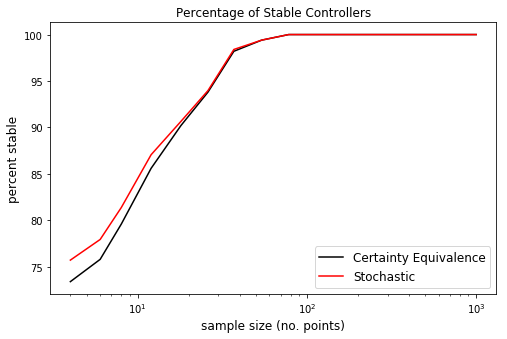

In [23]:
plt.figure(figsize=figsize)
plt.semilogx(sample_sizes[:], np.array(stable_ce) * 100, "k")
plt.semilogx(sample_sizes[:], np.array(stable_stoch) * 100, "r")
plt.xlabel("sample size (no. points)")
plt.ylabel("percent stable")
plt.title("Percentage of Stable Controllers")
plt.legend(("Certainty Equivalence","Stochastic"))
if save_figs:
    plt.savefig(save_dir + "low_noise_constr_percents.png")

In [24]:
def get_costs(data):
    return data[COST_CE], data[COST_STOCH]

def get_stable_costs(data):
    return np.array(data[COST_CE])[data[STABLE_CE]], np.array(data[COST_STOCH])[data[STABLE_STOCH]]

costs_ce, costs_stoch = zip(*[get_costs(d) for d in exp_data])
stable_costs_ce, stable_costs_stoch = zip(*[get_stable_costs(d) for d in exp_data])

479.549249343317


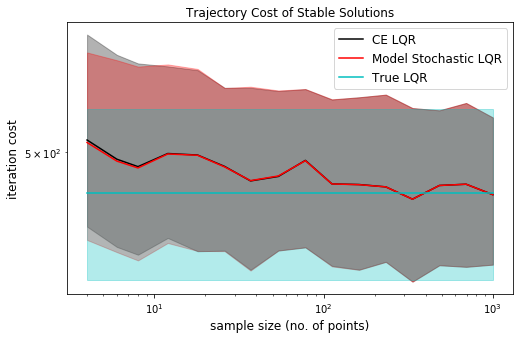

In [25]:
plt.figure(figsize=figsize)
plot_with_bars_qts(sample_sizes[:],stable_costs_ce,"k",loglog=True)
plot_with_bars_qts(sample_sizes[:], stable_costs_stoch, "r", loglog=True)
plot_with_bars_qts(sample_sizes[:], [true_lqr_costs]*len(sample_sizes),"c", loglog=True)
plt.ylabel("iteration cost")
plt.xlabel("sample size (no. of points)")
plt.title("Trajectory Cost of Stable Solutions")
plt.legend(("CE LQR", "Model Stochastic LQR", "True LQR"))
if save_figs:
    plt.savefig(save_dir + "low_noise_constr_traj_costs.png")
# plt.ylim((0,4000))
print(np.mean(true_lqr_costs))

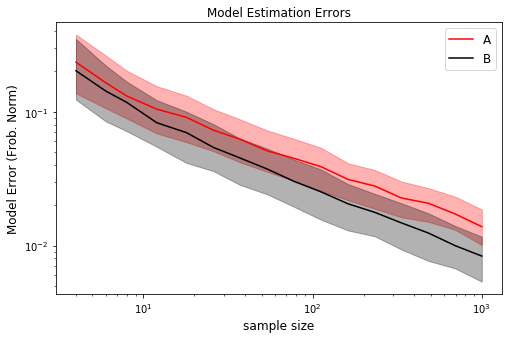

In [26]:
# data = np.load(save_dir + "low_noise_constr_data.npz", allow_pickle=True)
plt.figure(figsize=figsize)
A_errors = [[np.linalg.norm(A_true - A_est) for A_est in d[A_EST]]for d in exp_data]
B_errors = [[np.linalg.norm(B_true - B_est) for B_est in d[B_EST]]for d in exp_data]
plot_with_bars_qts(sample_sizes[:], A_errors, "r", loglog=True)
plot_with_bars_qts(sample_sizes[:], B_errors, "k", loglog=True)
plt.xlabel("sample size")
plt.ylabel("Model Error (Frob. Norm)")
plt.title("Model Estimation Errors")
plt.legend(("A", "B"))
if save_figs:
    plt.savefig(save_dir + "low_noise_constr_model_errs.png")

In [75]:
save_dir = "model_lqr_expts_svd/exp_3/"
exp_data = np.load(save_dir + "low_noise_constr_data.npz", allow_pickle=True)
exp_data = exp_data["exp_data"]
exp_data_x = np.load(save_dir + "low_noise_constr_data_x.npz", allow_pickle=True)
exp_data_x = exp_data_x["exp_data"]

54


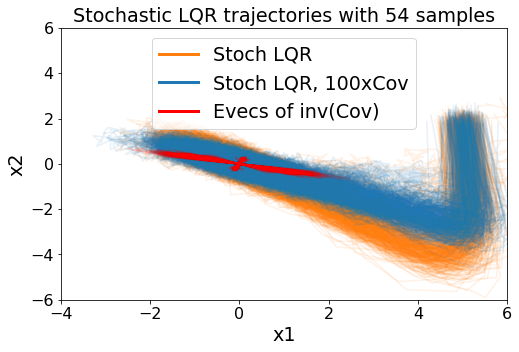

In [76]:

plt.figure(figsize=figsize)
sample_idx = 7
print(sample_sizes[sample_idx])
scale = 2e-3
covs_per_sample = [[np.linalg.eig(c) for c in data[COV]] for data in exp_data]
svds_per_sample = [[np.linalg.svd(np.hstack((x[:-1,:], u))) for x, u in zip(data[TRAJ_STOCH], data[INPUT_TRAJ_STOCH])] for data in exp_data]
for ce_traj, stoch_traj in zip(exp_data[sample_idx][TRAJ_CE], exp_data[sample_idx][TRAJ_STOCH]):
#     plt.plot(ce_traj[:,0], ce_traj[:,1], "tab:blue", alpha=0.1)
    plt.plot(stoch_traj[:,0], stoch_traj[:,1], "tab:orange", alpha=0.1, label="stoch")
    
for ce_traj, stoch_traj in zip(exp_data_x[sample_idx][TRAJ_CE], exp_data_x[sample_idx][TRAJ_STOCH]):
#     plt.plot(ce_traj[:,0], ce_traj[:,1], "tab:blue", alpha=0.1)
    plt.plot(stoch_traj[:,0], stoch_traj[:,1], "tab:blue", alpha=0.1, label="stoch X100")
    
for evals, evecs in covs_per_sample[sample_idx][:]:
    for i in range(len(evals)):
#         escale = abs(evals[i])
        escale = (1/np.abs(evals[i]))
        plt.arrow(0,0, scale * escale*evecs[0,i], scale * escale*evecs[1,i], alpha=.1, width=0.02, color="r",zorder=10, label="evec")
        plt.arrow(0,0, -scale * escale*evecs[0,i], -scale * escale*evecs[1,i], alpha=.1, width=0.02, color="r",zorder=10, label="evec")

# for U, S, V in svds_per_sample[sample_idx][:]:
# #     print(len(S))
#     sing_traj =   np.outer(U[:,0], V[0,:]) * S[0] 
#     plt.plot(sing_traj[:,0], sing_traj[:,1], "tab:orange", alpha=.11)
# x_traj, u_traj, cost = get_true_trajectory(episode_length)
# print(cost)
U,S,V = np.linalg.svd(np.hstack((x_traj[:-1,:],u_traj)))
svec = 0
sing_traj =   np.outer(U[:,svec], V[svec,:]) * S[svec] 
# plt.plot(sing_traj[:,0], sing_traj[:,1], "tab:green", alpha=1, lw=10)

# print(sing_traj.shape)
plt.xlim((-4,6))
plt.ylim((-6,6))
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Stochastic LQR trajectories with %d samples" % sample_sizes[sample_idx])
ax = plt.gca()
colors = ["tab:orange", "tab:blue", "r"]
import matplotlib.lines
lines = [matplotlib.lines.Line2D([0],[0], color=c, lw=3) for c in colors]
ax.legend(lines, ["Stoch LQR", "Stoch LQR, 100xCov", "Evecs of inv(Cov)"])
if save_figs:
    plt.savefig(save_dir + "low_noise_svd.png")

## DATA with COV x 100

In [28]:
exp_data_x = [run_experiment(num_data_points, cov_multiplier=100) for num_data_points in sample_sizes[:]]
if save_figs:
    np.savez(save_dir + "low_noise_constr_data_x.npz", exp_data=exp_data_x)

100%|███████████████████████████████████████████████████████████████████████| 500/500 [01:34<00:00,  5.28it/s]


In [29]:
stable_ce, stable_stoch = zip(*[pct_stable(d) for d in exp_data_x])
print([np.sum(d[CONVERGED])for d in exp_data_x])
print(sample_sizes)

[19, 51, 123, 221, 317, 395, 454, 486, 490, 499, 500, 500, 500, 500, 500, 500]
[   4    6    8   12   18   26   37   54   78  112  162  233  335  483
  695 1000]


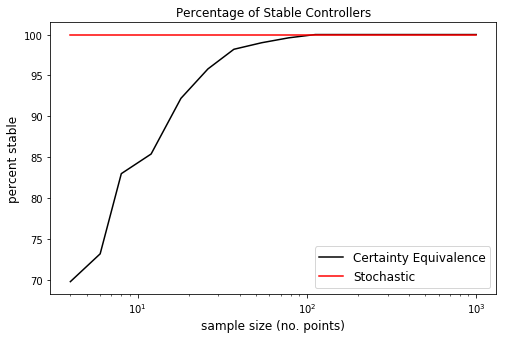

In [30]:
plt.figure(figsize=figsize)
plt.semilogx(sample_sizes[:], np.array(stable_ce) * 100, "k")
plt.semilogx(sample_sizes[:], np.array(stable_stoch) * 100, "r")
plt.xlabel("sample size (no. points)")
plt.ylabel("percent stable")
plt.title("Percentage of Stable Controllers")
plt.legend(("Certainty Equivalence","Stochastic"))
if save_figs:
    plt.savefig(save_dir + "low_noise_constr_percents_x.png")

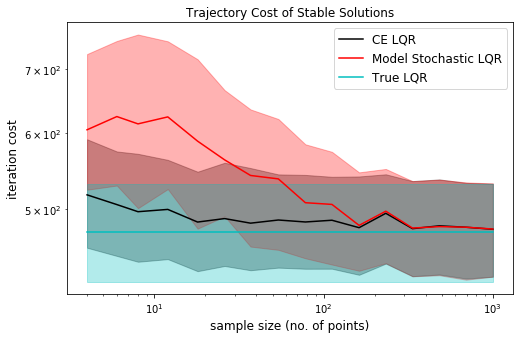

In [31]:
stable_costs_ce, stable_costs_stoch = zip(*[get_stable_costs(d) for d in exp_data_x])

plt.figure(figsize=figsize)
plot_with_bars_qts(sample_sizes[:],stable_costs_ce,"k",loglog=True)
plot_with_bars_qts(sample_sizes[:], stable_costs_stoch, "r", loglog=True)
plot_with_bars_qts(sample_sizes[:], [true_lqr_costs]*len(sample_sizes),"c", loglog=True)
plt.ylabel("iteration cost")
plt.xlabel("sample size (no. of points)")
plt.title("Trajectory Cost of Stable Solutions")
plt.legend(("CE LQR", "Model Stochastic LQR", "True LQR"))
if save_figs:
    plt.savefig(save_dir + "low_noise_constr_traj_costs_x.png")
# plt.ylim((0,4000))
# plt.ylim((0,4000))

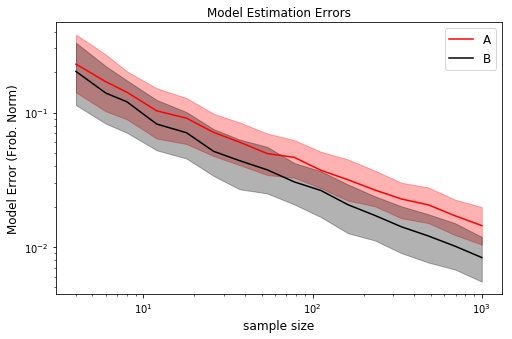

In [32]:
A_errors = [[np.linalg.norm(A_true - A_est) for A_est in d[A_EST]]for d in exp_data_x]
B_errors = [[np.linalg.norm(B_true - B_est) for B_est in d[B_EST]]for d in exp_data_x]
plt.figure(figsize=figsize)
plot_with_bars_qts(sample_sizes, A_errors, "r", loglog=True)
plot_with_bars_qts(sample_sizes, B_errors, "k", loglog=True)
plt.xlabel("sample size")
plt.ylabel("Model Error (Frob. Norm)")
plt.title("Model Estimation Errors")
plt.legend(("A", "B"))
if save_figs:
    plt.savefig(save_dir + "low_noise_constr_model_errs_x.png")

In [33]:
costs_x_mean = [np.mean(np.array(d[COST_STOCH])[d[STABLE_STOCH]]) for d in exp_data_x]
costs_mean = [np.mean(np.array(d[COST_STOCH])[d[STABLE_STOCH]]) for d in exp_data]

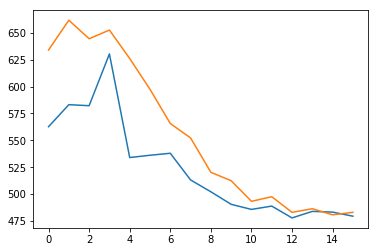

In [34]:
plt.plot(costs_mean)
plt.plot(costs_x_mean)

In [69]:
U, S, V = np.linalg.svd(np.hstack((exp_data[0][TRAJ_STOCH][0][:-1,:],exp_data[0][INPUT_TRAJ_STOCH][0])))

In [130]:
V.shape

(3, 3)

In [31]:
A = np.array([[0,1],[0,0]])
B = np.array([[0],[1]])
controlpy.synthesis.controller_lqr(A, B, Q*100, R)

(array([[10.        , 10.95445115]]), array([[109.5445115 ,  10.        ],
        [ 10.        ,  10.95445115]]), array([-1.00508962, -9.94936153]))